In [10]:
# Data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Text preprocessing
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Model building
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support

# Model persistence
import pickle
import joblib

import nltk

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')


# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [11]:
# Load dataset
df = pd.read_csv('../data/data.csv')
#df = pd.read_csv(r'C:\Users\HP\OneDrive\Desktop\flipkart_sentiment_analysis\
    #flipkart_sentiment_analysis\data\data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (8518, 8)

Column names: ['Reviewer Name', 'Review Title', 'Place of Review', 'Up Votes', 'Down Votes', 'Month', 'Review text', 'Ratings']

First few rows:


,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [12]:
df.columns = df.columns.str.strip()

In [13]:
# Dataset information
print("Dataset Info:")
print(df.info())
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nBasic Statistics:")
print(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB
None


Missing Values:
Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64


Basic Statistics:
          Up Votes   Down Votes      Ratings
count  8508.000000  8508.000000  8518.000000
mean      0.391396     0.1

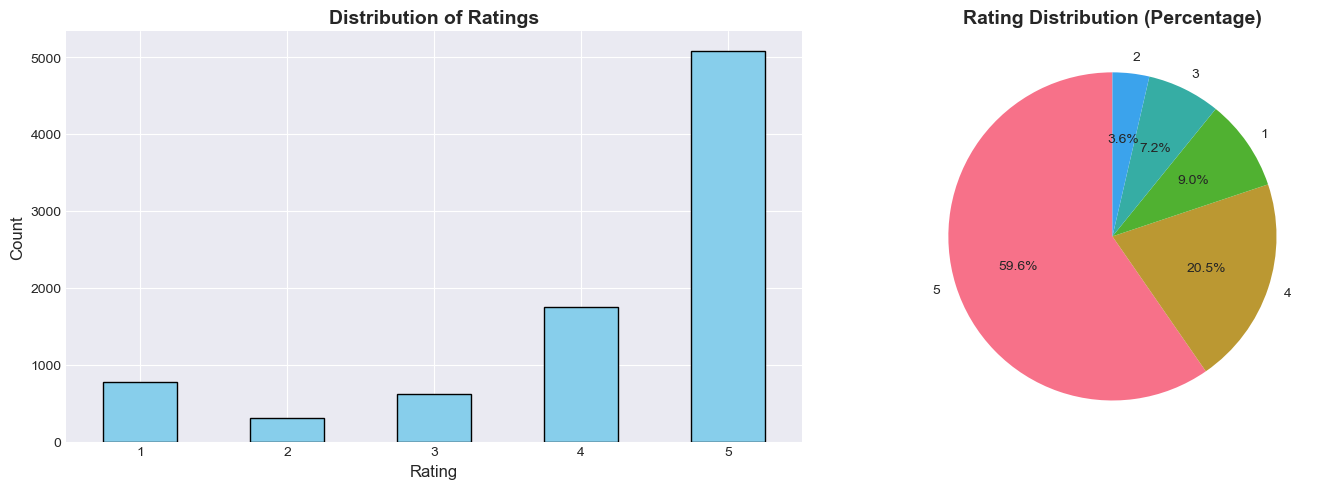


Rating Distribution:
Ratings
1     769
2     308
3     615
4    1746
5    5080
Name: count, dtype: int64


In [14]:
#EDA
#Rating distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
df['Ratings'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='skyblue', edgecolor='black')
axes[0].set_title('Distribution of Ratings', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Pie chart
df['Ratings'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Rating Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

print("\nRating Distribution:")
print(df['Ratings'].value_counts().sort_index())

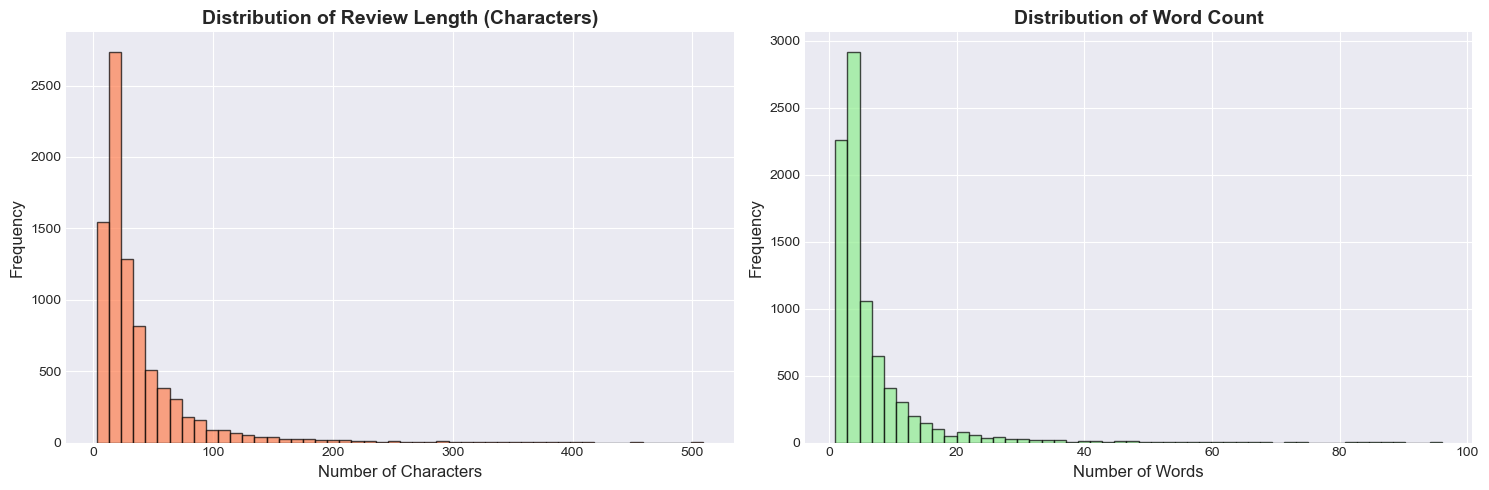

Average review length: 38.82 characters
Average word count: 6.30 words


In [15]:
# Review length analysis
df['review_length'] = df['Review text'].astype(str).apply(len)
df['word_count'] = df['Review text'].astype(str).apply(lambda x: len(x.split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Review length distribution
axes[0].hist(df['review_length'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution of Review Length (Characters)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Characters', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Word count distribution
axes[1].hist(df['word_count'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_title('Distribution of Word Count', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Words', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()

print(f"Average review length: {df['review_length'].mean():.2f} characters")
print(f"Average word count: {df['word_count'].mean():.2f} words")

In [16]:
# 1. Drop 'Reviewer Name' (not useful for analysis)
df.drop(columns=["Reviewer Name"], inplace=True)


In [17]:
# 2. Handle Review Title
# Fill missing titles with empty string so concatenation works safely
df["Review Title"].fillna("", inplace=True)


In [18]:
# 3. Drop rows where Review Text is missing (very important for NLP)
df = df.dropna(subset=["Review text"])


In [19]:
# 4. Combine Review Title and Review Text into a single column
df["full_review"] = (df["Review Title"] + " " + df["Review text"]).str.strip()


In [20]:
# 5. Handle Place of Review (keep it, fill missing values)
df["Place of Review"].fillna("Unknown", inplace=True)


In [21]:
# 6. Handle Up Votes and Down Votes (keep them, fill missing with 0)
df["Up Votes"].fillna(0, inplace=True)
df["Down Votes"].fillna(0, inplace=True)


In [22]:
# 7. Drop 'Month' column (optional metadata, not required)
df.drop(columns=["Month"], inplace=True)


In [23]:
df

,Review Title,Place of Review,Up Votes,Down Votes,Review text,Ratings,review_length,word_count,full_review
0,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,"Nice product, good quality, but price is now r...",4,204,37,"Nice product Nice product, good quality, but p..."
1,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,They didn't supplied Yonex Mavis 350. Outside ...,1,118,20,Don't waste your money They didn't supplied Yo...
2,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Worst product. Damaged shuttlecocks packed in ...,1,157,24,Did not meet expectations Worst product. Damag...
3,Fair,"Certified Buyer, Chennai",25.0,1.0,"Quite O. K. , but nowadays the quality of the...",3,388,81,"Fair Quite O. K. , but nowadays the quality o..."
4,Over priced,Unknown,147.0,24.0,Over pricedJust â?¹620 ..from retailer.I didn'...,1,114,17,Over priced Over pricedJust â?¹620 ..from reta...
...,...,...,...,...,...,...,...,...,...
8505,Very Good,Unknown,1.0,0.0,Delivered before time but price is high from m...,3,60,10,Very Good Delivered before time but price is h...
8506,Don't waste your money,Unknown,0.0,2.0,up to the mark but same is available in market...,4,70,14,Don't waste your money up to the mark but same...
8507,Really Nice,"Certified Buyer, Agartala",0.0,1.0,Nice delivery speedREAD MORE,5,28,4,Really Nice Nice delivery speedREAD MORE
8508,,Unknown,0.0,0.0,No complaints about the item . Its the best on...,5,159,30,No complaints about the item . Its the best on...


In [24]:
df.shape


(8510, 9)

In [25]:
df[["full_review", "Ratings"]].isnull().sum()


full_review    0
Ratings        0
dtype: int64

In [26]:
df.columns


Index(['Review Title', 'Place of Review', 'Up Votes', 'Down Votes',
       'Review text', 'Ratings', 'review_length', 'word_count', 'full_review'],
      dtype='object')

In [27]:
df.isnull().sum()


Review Title       0
Place of Review    0
Up Votes           0
Down Votes         0
Review text        0
Ratings            0
review_length      0
word_count         0
full_review        0
dtype: int64

In [28]:
df.drop(columns=["Review Title", "Review text"], inplace=True)


In [29]:
df.columns

Index(['Place of Review', 'Up Votes', 'Down Votes', 'Ratings', 'review_length',
       'word_count', 'full_review'],
      dtype='object')

In [30]:
df


,Place of Review,Up Votes,Down Votes,Ratings,review_length,word_count,full_review
0,"Certified Buyer, Chirakkal",889.0,64.0,4,204,37,"Nice product Nice product, good quality, but p..."
1,"Certified Buyer, Hyderabad",109.0,6.0,1,118,20,Don't waste your money They didn't supplied Yo...
2,"Certified Buyer, Dharmapuri",42.0,3.0,1,157,24,Did not meet expectations Worst product. Damag...
3,"Certified Buyer, Chennai",25.0,1.0,3,388,81,"Fair Quite O. K. , but nowadays the quality o..."
4,Unknown,147.0,24.0,1,114,17,Over priced Over pricedJust â?¹620 ..from reta...
...,...,...,...,...,...,...,...
8505,Unknown,1.0,0.0,3,60,10,Very Good Delivered before time but price is h...
8506,Unknown,0.0,2.0,4,70,14,Don't waste your money up to the mark but same...
8507,"Certified Buyer, Agartala",0.0,1.0,5,28,4,Really Nice Nice delivery speedREAD MORE
8508,Unknown,0.0,0.0,5,159,30,No complaints about the item . Its the best on...


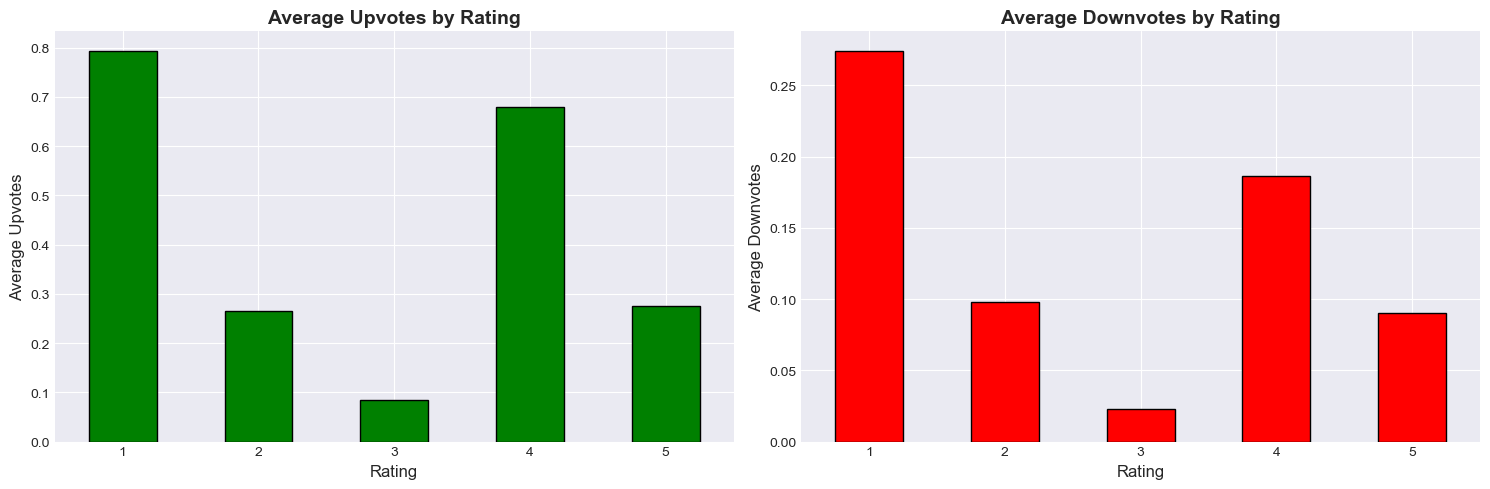

In [31]:
# Upvotes and Downvotes analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Upvotes by rating
df.groupby('Ratings')['Up Votes'].mean().plot(kind='bar', ax=axes[0], color='green', edgecolor='black')
axes[0].set_title('Average Upvotes by Rating', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Rating', fontsize=12)
axes[0].set_ylabel('Average Upvotes', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)

# Downvotes by rating
df.groupby('Ratings')['Down Votes'].mean().plot(kind='bar', ax=axes[1], color='red', edgecolor='black')
axes[1].set_title('Average Downvotes by Rating', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Rating', fontsize=12)
axes[1].set_ylabel('Average Downvotes', fontsize=12)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

Analysis of average upvotes and downvotes by rating shows that negative reviews receive higher engagement, indicating their influence on customer perception. However, since votes reflect post-review reactions, they were used only for insights and not as model features.

In [32]:
# Create sentiment labels
def create_sentiment(rating):
    if rating <= 2:
        return 0  # Negative
    elif rating >= 4:
        return 1  # Positive
    else:
        return 2  # Neutral (will be removed)

df['sentiment'] = df['Ratings'].apply(create_sentiment)

# Remove neutral reviews for binary classification
df_binary = df[df['sentiment'] != 2].copy()

print(f"Original dataset size: {len(df)}")
print(f"Binary dataset size: {len(df_binary)}")
print(f"Removed neutral reviews: {len(df) - len(df_binary)}")
print(f"\nSentiment distribution:")
print(df_binary['sentiment'].value_counts())
print(f"\nClass balance:")
print(df_binary['sentiment'].value_counts(normalize=True) * 100)

Original dataset size: 8510
Binary dataset size: 7895
Removed neutral reviews: 615

Sentiment distribution:
sentiment
1    6823
0    1072
Name: count, dtype: int64

Class balance:
sentiment
1    86.421786
0    13.578214
Name: proportion, dtype: float64


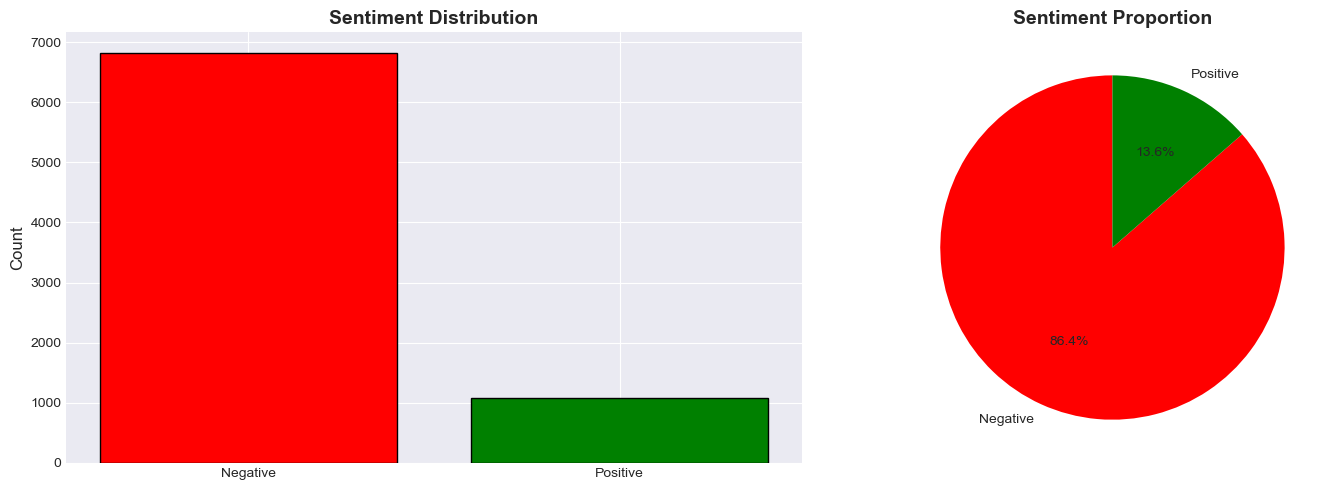

In [33]:
# Visualize sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
sentiment_counts = df_binary['sentiment'].value_counts()
axes[0].bar(['Negative', 'Positive'], sentiment_counts.values, color=['red', 'green'], edgecolor='black')
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12)

# Pie chart
axes[1].pie(sentiment_counts.values, labels=['Negative', 'Positive'], autopct='%1.1f%%',
            colors=['red', 'green'], startangle=90)
axes[1].set_title('Sentiment Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [34]:
# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """
    Comprehensive text cleaning function
    """
    # Convert to string and lowercase
    text = str(text).lower()

    # Remove 'READ MORE' tag
    text = re.sub(r'read more', '', text, flags=re.IGNORECASE)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def preprocess_text(text, use_lemmatization=True):
    """
    Complete preprocessing pipeline
    """
    # Clean text
    text = clean_text(text)

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords and short words
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lemmatization or Stemming
    if use_lemmatization:
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    else:
        tokens = [stemmer.stem(word) for word in tokens]

    return ' '.join(tokens)

# Apply preprocessing
print("Preprocessing text data...")
df_binary['cleaned_review'] = df_binary['full_review'].apply(lambda x: preprocess_text(x, use_lemmatization=True))

print("✅ Text preprocessing completed!")
print("\nExample:")
print(f"Original: {df_binary['full_review'].iloc[0]}")
print(f"Cleaned: {df_binary['cleaned_review'].iloc[0]}")

Preprocessing text data...
✅ Text preprocessing completed!

Example:
Original: Nice product Nice product, good quality, but price is now rising which is a bad sign. 800-850 was an affordable price, especially when we play everyday. So kindly help us out in terms of the price. Thank You.READ MORE
Cleaned: nice product nice product good quality price rising bad sign affordable price especially play everyday kindly help term price thank


In [35]:
# Remove empty reviews after cleaning
df_binary = df_binary[df_binary['cleaned_review'].str.strip().str.len() > 0]
print(f"Dataset size after removing empty reviews: {len(df_binary)}")

Dataset size after removing empty reviews: 7895


##  Feature Extraction

We'll experiment with multiple text embedding techniques:
1. **Bag of Words (BoW)**
2. **TF-IDF**

In [36]:
# Prepare data
X = df_binary['cleaned_review']
y = df_binary['sentiment']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"\nTraining set sentiment distribution:\n{y_train.value_counts()}")
print(f"\nTest set sentiment distribution:\n{y_test.value_counts()}")

Training set size: 6316
Test set size: 1579

Training set sentiment distribution:
sentiment
1    5458
0     858
Name: count, dtype: int64

Test set sentiment distribution:
sentiment
1    1365
0     214
Name: count, dtype: int64


In [37]:
# 1. Bag of Words (BoW)
print("Creating Bag of Words features...")
bow_vectorizer = CountVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

print(f"BoW feature shape: {X_train_bow.shape}")
print("✅ BoW features created!")

Creating Bag of Words features...
BoW feature shape: (6316, 5000)
✅ BoW features created!


In [38]:
# 2. TF-IDF
print("Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF feature shape: {X_train_tfidf.shape}")
print("✅ TF-IDF features created!")

Creating TF-IDF features...
TF-IDF feature shape: (6316, 5000)
✅ TF-IDF features created!


#Model Training and Evaluation

We'll train and compare multiple models:
1. Logistic Regression
2. Naive Bayes
3. Random Forest
4. Support Vector Machine
5. XGBoost

In [39]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a model
    """
    print(f"\n{'='*60}")
    print(f"Training {model_name}...")
    print(f"{'='*60}")

    # Train model
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\n📊 Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    plt.show()

    return model, accuracy, f1

###  Models with Bag of Words


Training Logistic Regression (BoW)...

📊 Results for Logistic Regression (BoW):
Accuracy: 0.9278
F1-Score: 0.9225

Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.59      0.69       214
    Positive       0.94      0.98      0.96      1365

    accuracy                           0.93      1579
   macro avg       0.88      0.78      0.82      1579
weighted avg       0.92      0.93      0.92      1579



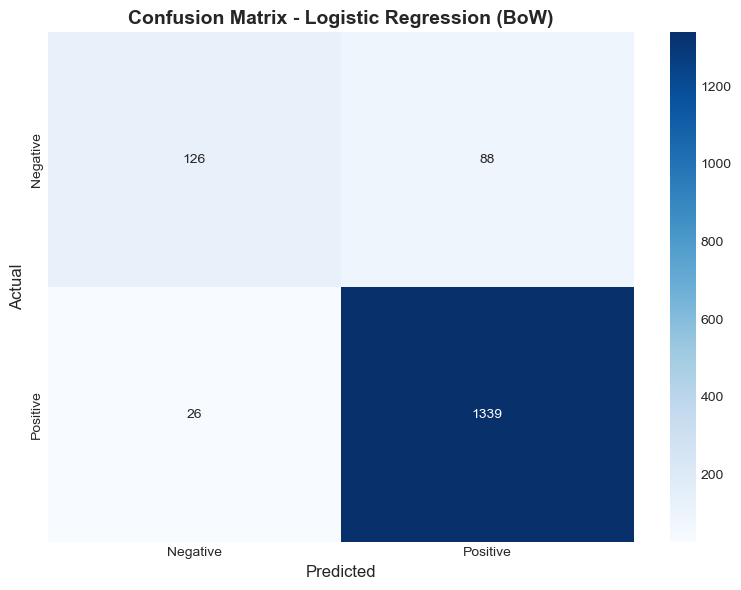


Training Naive Bayes (BoW)...

📊 Results for Naive Bayes (BoW):
Accuracy: 0.9196
F1-Score: 0.9157

Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.60      0.67       214
    Positive       0.94      0.97      0.95      1365

    accuracy                           0.92      1579
   macro avg       0.85      0.79      0.81      1579
weighted avg       0.91      0.92      0.92      1579



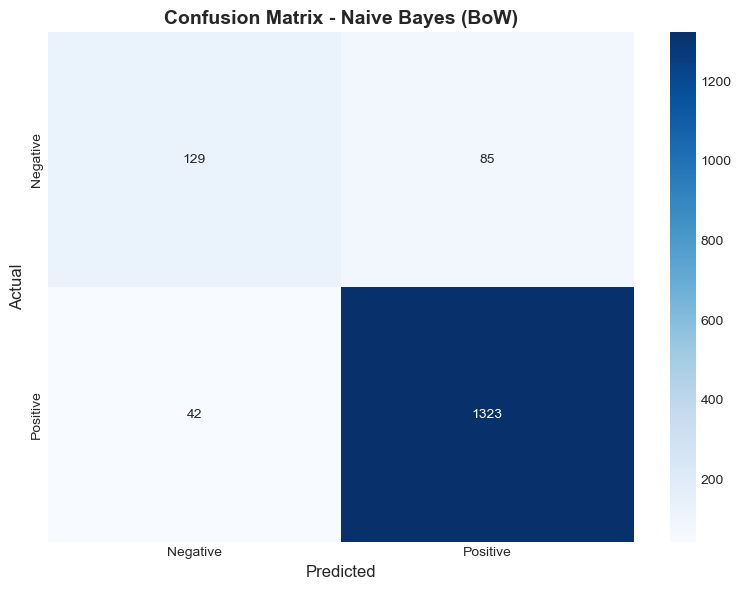


Training Random Forest (BoW)...

📊 Results for Random Forest (BoW):
Accuracy: 0.9107
F1-Score: 0.9037

Classification Report:
              precision    recall  f1-score   support

    Negative       0.74      0.52      0.61       214
    Positive       0.93      0.97      0.95      1365

    accuracy                           0.91      1579
   macro avg       0.84      0.75      0.78      1579
weighted avg       0.90      0.91      0.90      1579



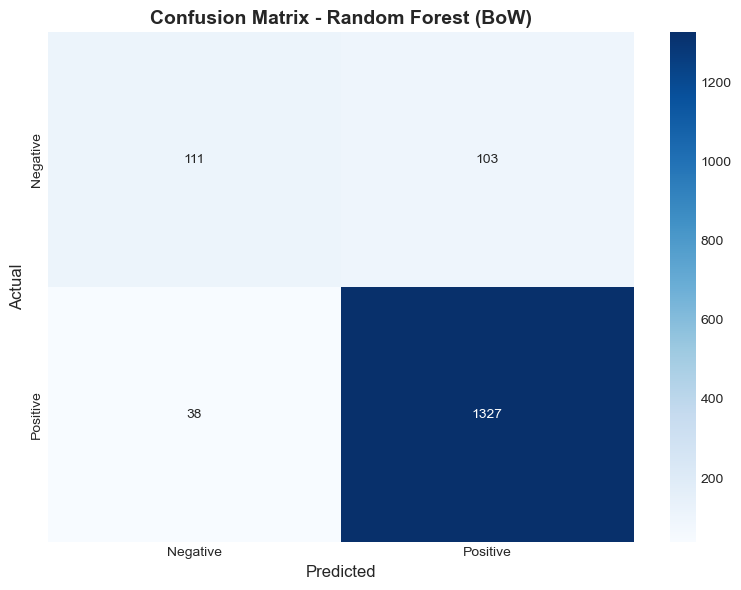

In [40]:
# Store results
results_bow = {}

# 1. Logistic Regression
lr_bow = LogisticRegression(max_iter=1000, random_state=42)
lr_bow_trained, lr_bow_acc, lr_bow_f1 = evaluate_model(lr_bow, X_train_bow, X_test_bow, y_train, y_test,
                                                         "Logistic Regression (BoW)")
results_bow['Logistic Regression'] = {'accuracy': lr_bow_acc, 'f1_score': lr_bow_f1}

# 2. Naive Bayes
nb_bow = MultinomialNB()
nb_bow_trained, nb_bow_acc, nb_bow_f1 = evaluate_model(nb_bow, X_train_bow, X_test_bow, y_train, y_test,
                                                         "Naive Bayes (BoW)")
results_bow['Naive Bayes'] = {'accuracy': nb_bow_acc, 'f1_score': nb_bow_f1}

# 3. Random Forest
rf_bow = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_bow_trained, rf_bow_acc, rf_bow_f1 = evaluate_model(rf_bow, X_train_bow, X_test_bow, y_train, y_test,
                                                         "Random Forest (BoW)")
results_bow['Random Forest'] = {'accuracy': rf_bow_acc, 'f1_score': rf_bow_f1}

###  Models with TF-IDF


Training Logistic Regression (TF-IDF)...

📊 Results for Logistic Regression (TF-IDF):
Accuracy: 0.9177
F1-Score: 0.9086

Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.50      0.62       214
    Positive       0.93      0.98      0.95      1365

    accuracy                           0.92      1579
   macro avg       0.88      0.74      0.79      1579
weighted avg       0.91      0.92      0.91      1579



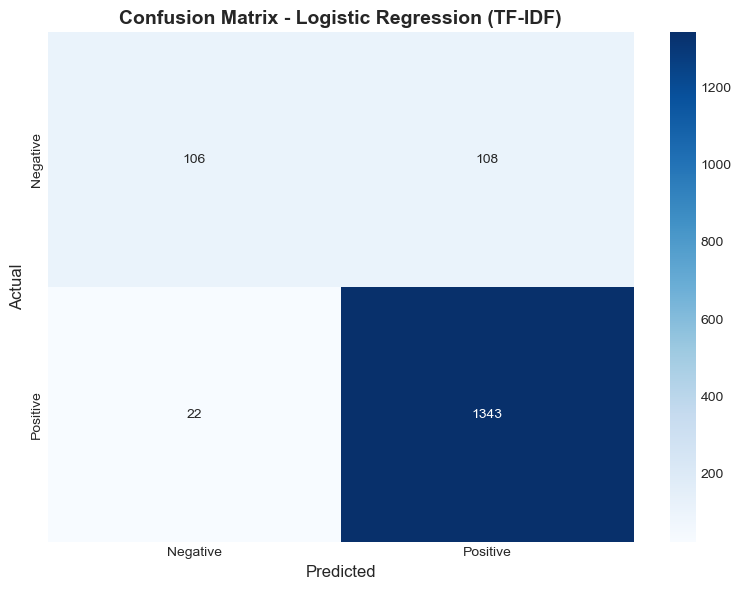


Training Naive Bayes (TF-IDF)...

📊 Results for Naive Bayes (TF-IDF):
Accuracy: 0.9025
F1-Score: 0.8825

Classification Report:
              precision    recall  f1-score   support

    Negative       0.88      0.33      0.48       214
    Positive       0.90      0.99      0.95      1365

    accuracy                           0.90      1579
   macro avg       0.89      0.66      0.71      1579
weighted avg       0.90      0.90      0.88      1579



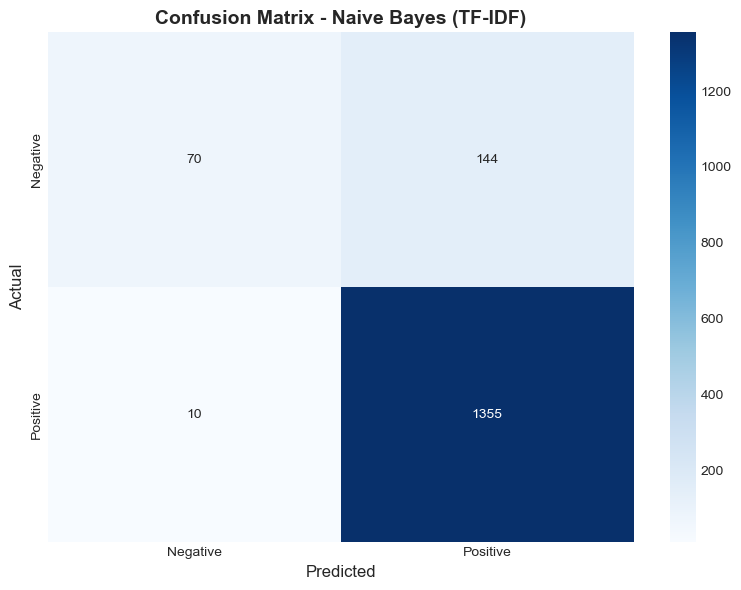


Training Random Forest (TF-IDF)...

📊 Results for Random Forest (TF-IDF):
Accuracy: 0.9158
F1-Score: 0.9090

Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.53      0.63       214
    Positive       0.93      0.98      0.95      1365

    accuracy                           0.92      1579
   macro avg       0.85      0.75      0.79      1579
weighted avg       0.91      0.92      0.91      1579



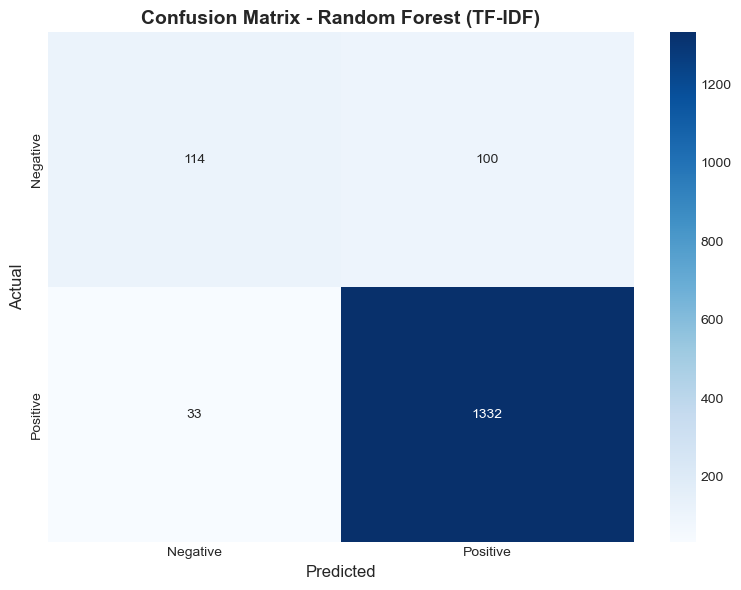


Training SVM (TF-IDF)...

📊 Results for SVM (TF-IDF):
Accuracy: 0.9253
F1-Score: 0.9200

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.58      0.68       214
    Positive       0.94      0.98      0.96      1365

    accuracy                           0.93      1579
   macro avg       0.87      0.78      0.82      1579
weighted avg       0.92      0.93      0.92      1579



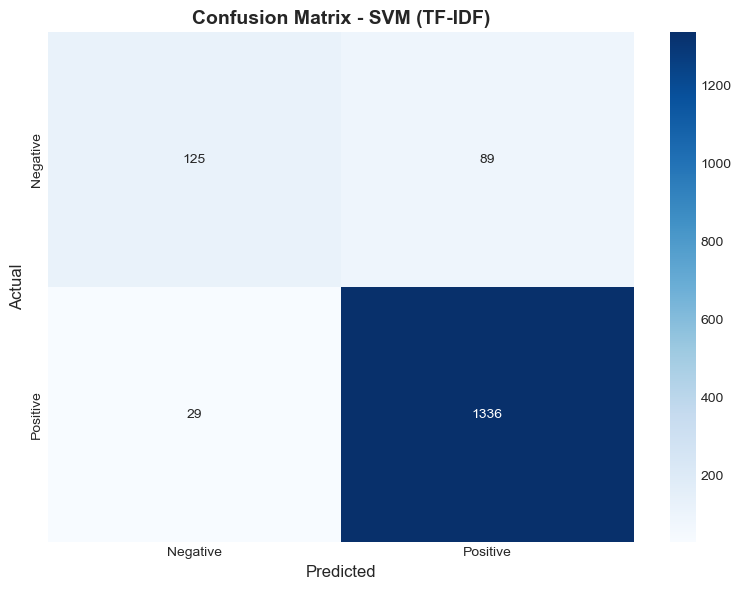


Training XGBoost (TF-IDF)...

📊 Results for XGBoost (TF-IDF):
Accuracy: 0.9196
F1-Score: 0.9126

Classification Report:
              precision    recall  f1-score   support

    Negative       0.80      0.54      0.64       214
    Positive       0.93      0.98      0.95      1365

    accuracy                           0.92      1579
   macro avg       0.87      0.76      0.80      1579
weighted avg       0.91      0.92      0.91      1579



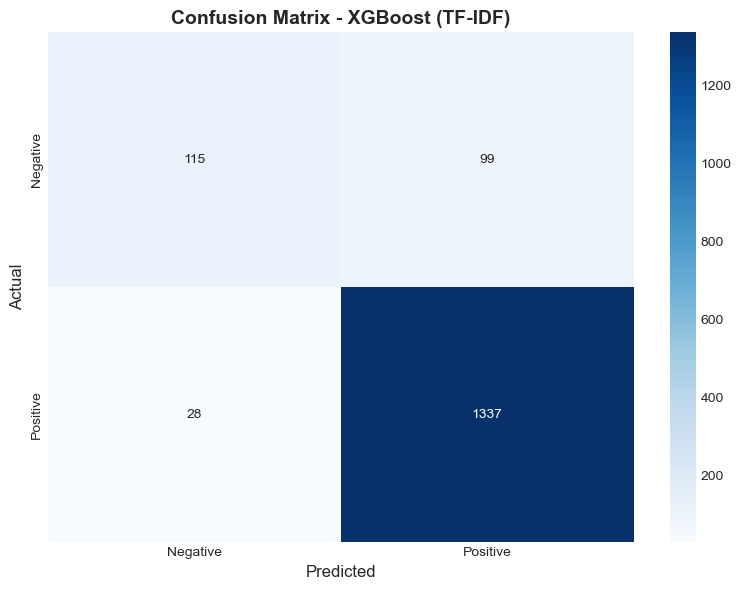

In [41]:
# Store results
results_tfidf = {}

# 1. Logistic Regression
lr_tfidf = LogisticRegression(max_iter=1000, random_state=42)
lr_tfidf_trained, lr_tfidf_acc, lr_tfidf_f1 = evaluate_model(lr_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test,
                                                               "Logistic Regression (TF-IDF)")
results_tfidf['Logistic Regression'] = {'accuracy': lr_tfidf_acc, 'f1_score': lr_tfidf_f1}

# 2. Naive Bayes
nb_tfidf = MultinomialNB()
nb_tfidf_trained, nb_tfidf_acc, nb_tfidf_f1 = evaluate_model(nb_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test,
                                                               "Naive Bayes (TF-IDF)")
results_tfidf['Naive Bayes'] = {'accuracy': nb_tfidf_acc, 'f1_score': nb_tfidf_f1}

# 3. Random Forest
rf_tfidf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_tfidf_trained, rf_tfidf_acc, rf_tfidf_f1 = evaluate_model(rf_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test,
                                                               "Random Forest (TF-IDF)")
results_tfidf['Random Forest'] = {'accuracy': rf_tfidf_acc, 'f1_score': rf_tfidf_f1}

# 4. SVM
svm_tfidf = SVC(kernel='linear', random_state=42)
svm_tfidf_trained, svm_tfidf_acc, svm_tfidf_f1 = evaluate_model(svm_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test,
                                                                  "SVM (TF-IDF)")
results_tfidf['SVM'] = {'accuracy': svm_tfidf_acc, 'f1_score': svm_tfidf_f1}

# 5. XGBoost
xgb_tfidf = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_tfidf_trained, xgb_tfidf_acc, xgb_tfidf_f1 = evaluate_model(xgb_tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test,
                                                                  "XGBoost (TF-IDF)")
results_tfidf['XGBoost'] = {'accuracy': xgb_tfidf_acc, 'f1_score': xgb_tfidf_f1}

## Model Comparison

In [42]:
# Create comparison dataframe
comparison_data = []

for model_name, metrics in results_bow.items():
    comparison_data.append({
        'Model': model_name,
        'Feature': 'BoW',
        'Accuracy': metrics['accuracy'],
        'F1-Score': metrics['f1_score']
    })

for model_name, metrics in results_tfidf.items():
    comparison_data.append({
        'Model': model_name,
        'Feature': 'TF-IDF',
        'Accuracy': metrics['accuracy'],
        'F1-Score': metrics['f1_score']
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON RESULTS")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)


MODEL COMPARISON RESULTS
              Model Feature  Accuracy  F1-Score
Logistic Regression     BoW  0.927802  0.922489
                SVM  TF-IDF  0.925269  0.919981
        Naive Bayes     BoW  0.919569  0.915701
            XGBoost  TF-IDF  0.919569  0.912591
      Random Forest  TF-IDF  0.915769  0.908962
Logistic Regression  TF-IDF  0.917669  0.908575
      Random Forest     BoW  0.910703  0.903746
        Naive Bayes  TF-IDF  0.902470  0.882525


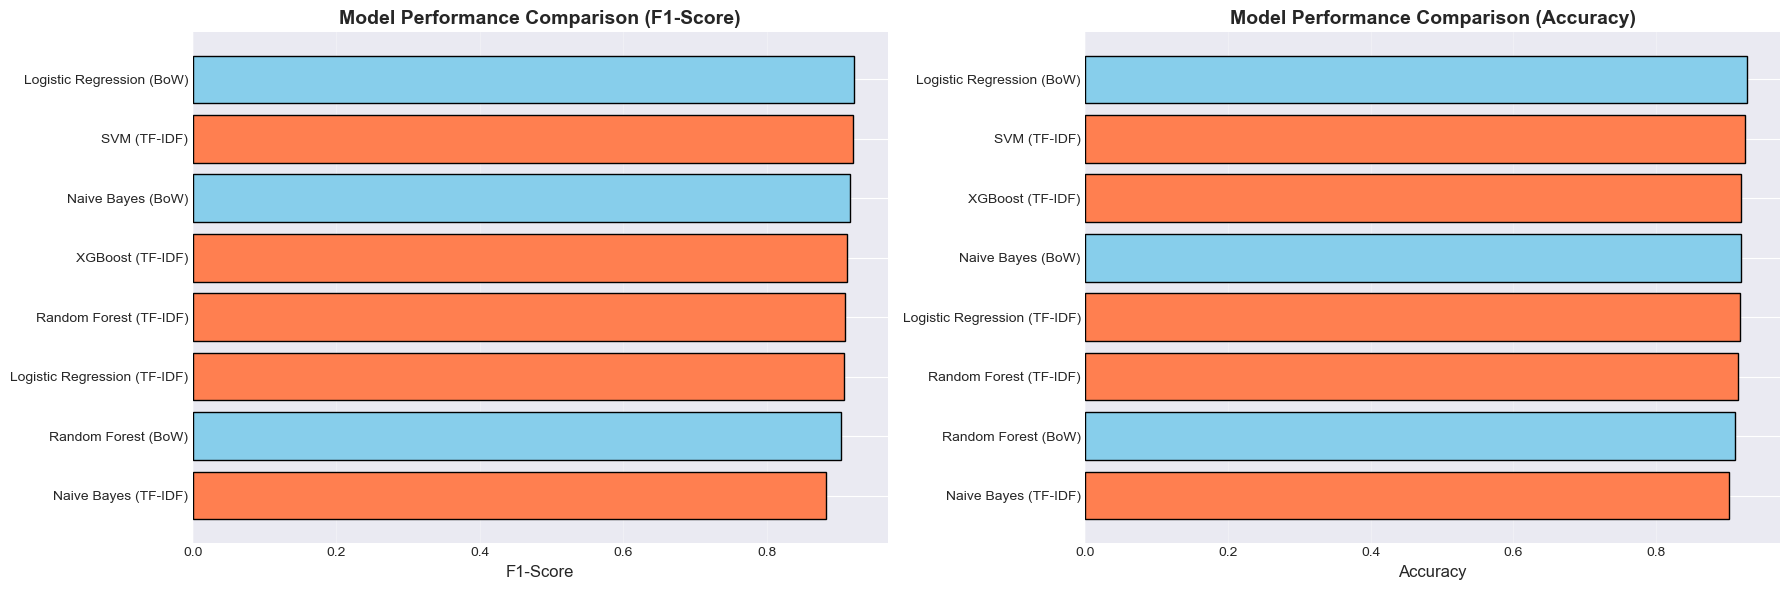


🏆 BEST MODEL: Logistic Regression with BoW
   F1-Score: 0.9225
   Accuracy: 0.9278


In [43]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# F1-Score comparison
comparison_df_sorted = comparison_df.sort_values('F1-Score', ascending=True)
colors = ['skyblue' if feat == 'BoW' else 'coral' for feat in comparison_df_sorted['Feature']]
axes[0].barh(range(len(comparison_df_sorted)), comparison_df_sorted['F1-Score'], color=colors, edgecolor='black')
axes[0].set_yticks(range(len(comparison_df_sorted)))
axes[0].set_yticklabels([f"{row['Model']} ({row['Feature']})" for _, row in comparison_df_sorted.iterrows()])
axes[0].set_xlabel('F1-Score', fontsize=12)
axes[0].set_title('Model Performance Comparison (F1-Score)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Accuracy comparison
comparison_df_sorted = comparison_df.sort_values('Accuracy', ascending=True)
colors = ['skyblue' if feat == 'BoW' else 'coral' for feat in comparison_df_sorted['Feature']]
axes[1].barh(range(len(comparison_df_sorted)), comparison_df_sorted['Accuracy'], color=colors, edgecolor='black')
axes[1].set_yticks(range(len(comparison_df_sorted)))
axes[1].set_yticklabels([f"{row['Model']} ({row['Feature']})" for _, row in comparison_df_sorted.iterrows()])
axes[1].set_xlabel('Accuracy', fontsize=12)
axes[1].set_title('Model Performance Comparison (Accuracy)', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Best model
best_model_row = comparison_df.iloc[0]
print(f"\n🏆 BEST MODEL: {best_model_row['Model']} with {best_model_row['Feature']}")
print(f"   F1-Score: {best_model_row['F1-Score']:.4f}")
print(f"   Accuracy: {best_model_row['Accuracy']:.4f}")

Multiple models were evaluated using Bag-of-Words and TF-IDF features. Logistic Regression with Bag-of-Words achieved the highest F1-score, indicating that simple linear models perform effectively on short and explicit customer reviews. More complex models such as Random Forest and XGBoost did not offer additional benefits due to the sparse nature of text features.

## Save Best Model and Vectorizer

In [49]:
import joblib
import dill

print("Saving the FINAL model and vectorizer...")

# ✅ Save Logistic Regression + BoW model
joblib.dump(lr_bow_trained, '../models/sentiment_model.pkl')
print("✅ Model saved: sentiment_model.pkl")

# ✅ Save BoW vectorizer
joblib.dump(bow_vectorizer, '../models/bow_vectorizer.pkl')
print("✅ Vectorizer saved: bow_vectorizer.pkl")

# ✅ Save preprocessing function
with open('../models/preprocess_function.pkl', 'wb') as f:
    dill.dump(preprocess_text, f)
print("✅ Preprocessing function saved: preprocess_function.pkl")

print("\n📦 All FINAL deployment artifacts saved successfully!")


Saving the FINAL model and vectorizer...
✅ Model saved: sentiment_model.pkl
✅ Vectorizer saved: bow_vectorizer.pkl
✅ Preprocessing function saved: preprocess_function.pkl

📦 All FINAL deployment artifacts saved successfully!


In [50]:
# Extract negative reviews
negative_reviews = df_binary[df_binary['sentiment'] == 0]['cleaned_review']

print(f"Total negative reviews: {len(negative_reviews)}")
print("\nSample negative reviews:")
for i, review in enumerate(negative_reviews.head(5), 1):
    print(f"{i}. {review}")

Total negative reviews: 1072

Sample negative reviews:
1. dont waste money didnt supplied yonex mavis outside cover yonex inside cheapest sad hear
2. meet expectation worst product damaged shuttlecock packed new box original yonex product dont buyflipkart platform chosen fraud buyer
3. priced pricedjust retaileri didnt understand wat advantage buying dis frm flipkrt
4. meet expectation second time getting opened bundle yonex mavis shuttle really believe original product someone may switched shuttle inside bundle dont buy flipkart gon return product
5. think duplicate usually buy model last even day


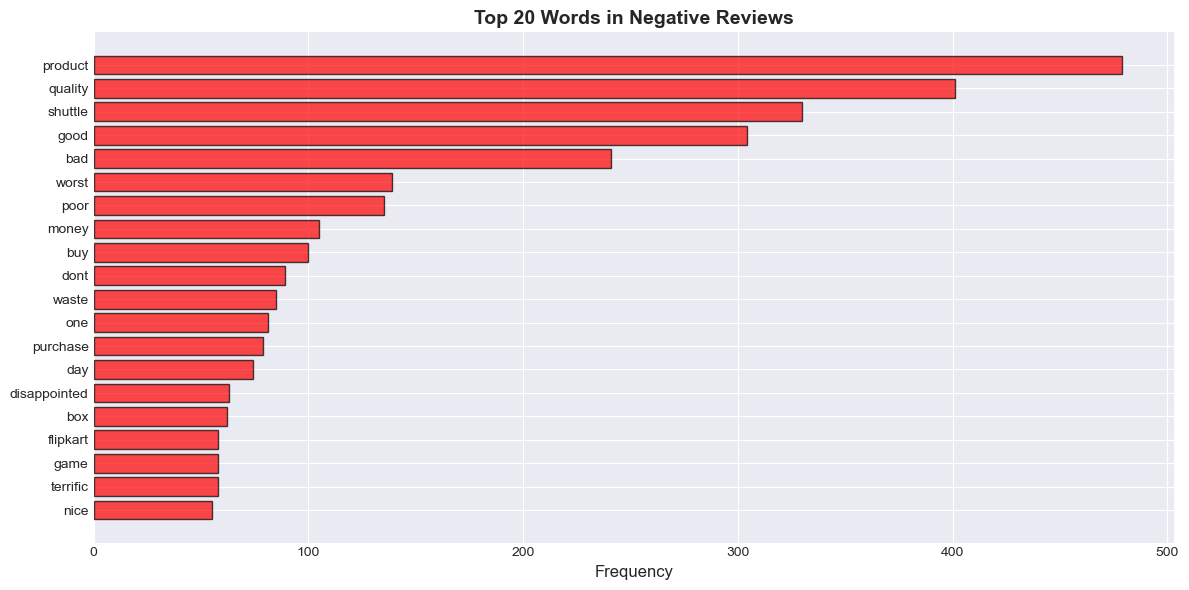


Top pain points (common words in negative reviews):
  • product: 479 occurrences
  • quality: 401 occurrences
  • shuttle: 330 occurrences
  • good: 304 occurrences
  • bad: 241 occurrences
  • worst: 139 occurrences
  • poor: 135 occurrences
  • money: 105 occurrences
  • buy: 100 occurrences
  • dont: 89 occurrences


In [51]:
# Word frequency in negative reviews
from collections import Counter

all_words = ' '.join(negative_reviews).split()
word_freq = Counter(all_words)
top_20_words = word_freq.most_common(20)

words, counts = zip(*top_20_words)

plt.figure(figsize=(12, 6))
plt.barh(range(len(words)), counts, color='red', edgecolor='black', alpha=0.7)
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency', fontsize=12)
plt.title('Top 20 Words in Negative Reviews', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop pain points (common words in negative reviews):")
for word, count in top_20_words[:10]:
    print(f"  • {word}: {count} occurrences")

In [52]:
def predict_sentiment(review_text, model, vectorizer, preprocess_func):
    """
    Predict sentiment for a custom review using Logistic Regression + BoW
    """
    # 1. Preprocess text
    cleaned = preprocess_func(review_text)

    # 2. Vectorize using BoW
    vectorized = vectorizer.transform([cleaned])

    # 3. Predict class
    prediction = model.predict(vectorized)[0]

    # 4. Predict probabilities
    prediction_proba = model.predict_proba(vectorized)[0]

    # 5. Format output
    sentiment = "POSITIVE 😊" if prediction == 1 else "NEGATIVE 😞"
    confidence = prediction_proba[prediction] * 100

    print(f"\nReview: {review_text}")
    print(f"Cleaned Review: {cleaned}")
    print(f"Sentiment: {sentiment}")
    print(f"Confidence: {confidence:.2f}%")
    print(f"Probability [Negative, Positive]: {prediction_proba}")

    return prediction, confidence


In [53]:
test_reviews = [
    "Excellent product! Best shuttlecock I've ever used. Highly recommended!",
    "Very poor quality. Damaged shuttles. Not worth the price.",
    "Good product but the price is too high. Quality is okay.",
    "Terrible experience. Fake product delivered. Do not buy!",
    "Amazing! Original Yonex product. Fast delivery. Very happy with purchase."
]

print("\n" + "="*80)
print("TESTING FINAL MODEL (Logistic Regression + BoW)")
print("="*80)

for review in test_reviews:
    predict_sentiment(
        review_text=review,
        model=lr_bow_trained,        # ✅ FINAL MODEL
        vectorizer=bow_vectorizer,   # ✅ FINAL VECTORIZER
        preprocess_func=preprocess_text
    )
    print("-" * 80)



TESTING FINAL MODEL (Logistic Regression + BoW)

Review: Excellent product! Best shuttlecock I've ever used. Highly recommended!
Cleaned Review: excellent product best shuttlecock ive ever used highly recommended
Sentiment: POSITIVE 😊
Confidence: 99.94%
Probability [Negative, Positive]: [5.56415547e-04 9.99443584e-01]
--------------------------------------------------------------------------------

Review: Very poor quality. Damaged shuttles. Not worth the price.
Cleaned Review: poor quality damaged shuttle worth price
Sentiment: NEGATIVE 😞
Confidence: 90.45%
Probability [Negative, Positive]: [0.90449542 0.09550458]
--------------------------------------------------------------------------------

Review: Good product but the price is too high. Quality is okay.
Cleaned Review: good product price high quality okay
Sentiment: POSITIVE 😊
Confidence: 85.41%
Probability [Negative, Positive]: [0.14587096 0.85412904]
----------------------------------------------------------------------------